In [108]:
# Standard imports
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

# Stats Models functions for Time Series Analysis
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose

In [161]:
# Plotly Imports
import plotly.offline as plotly
import plotly.graph_objs as go
from plotly import tools

plotly.init_notebook_mode(connected=False)

In [144]:
# Translate DataFrame into Plotly Figure
def plot_df(dataframe, title): 
    data = [go.Scatter(x=dataframe.index,
                                  y=dataframe[column],
                                  name=column) for column in dataframe.columns]
    layout = dict(title=title)
    fig = dict(data=data, layout=layout)
    return fig

In [179]:
# Helper to convert the dollars to numbers
def dollars_to_int(dollar_string):
    converted = dollar_string.rstrip('K').lstrip('$').replace(',','')
    try:
        converted = float(converted)
    except:
        converted = 'NaN'
    return converted

# Helper to convert the percentage points to numbers between 0 and 1
def pct_to_int(pct_string):
    converted = float(pct_string.rstrip('%')) / 100
    return converted

In [188]:
# Normalize Numpy Series Values between 0 and 1
def normalize_series(series):
    max_value = series.max()
    min_value = series.min()
    def normalize(number):
        return (number-min_value) / (max_value - min_value)
    series = series.apply(normalize)
    return series

In [130]:
# Define constants for pandas read_csv
converters = {
    'Median Sale Price': dollars_to_int,
    'Median List Price': dollars_to_int,
    
}
parse_dates = ['Period Begin', 'Period End']
index_col = ['City', 'Period End']
files = {
    'condos': 'redfin-bayarea-condos.csv',
    'single_family': 'redfin-bayarea-single-family.csv',
    'townhouse': 'redfin-bayarea-townhouse.csv',
    'multi_family': 'redfin-bayarea-multi-fam.csv'
}

cities = ['Oakland', 'Berkeley', 'San Ramon', 'Dublin', 'Fremont', 'Alameda']

In [131]:
def read_data(file, **kw):
    df = pd.read_csv(file, parse_dates=parse_dates, converters=converters, index_col=index_col)
    df.sort_index(inplace=True)
    return df

In [154]:
condos = read_data('redfin-bayarea-condos.csv')
single_family = read_data('redfin-bayarea-single-family.csv')
townhouse = read_data('redfin-bayarea-townhouse.csv')
multi_family = read_data('redfin-bayarea-multi-fam.csv')
all_homes = read_data('redfin-bayarea-all.csv')

In [247]:
all_homes.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 468 entries, (Alameda, 2012-01-31 00:00:00) to (San Ramon, 2018-06-30 00:00:00)
Data columns (total 47 columns):
Worksheet Filter         468 non-null object
Measure Display          0 non-null float64
Number of Records        468 non-null int64
Avg Sale To List         468 non-null float64
Avg Sale To List Mom     468 non-null object
Avg Sale To List Yoy     468 non-null object
Homes Sold               468 non-null int64
Homes Sold Mom           468 non-null object
Homes Sold Yoy           468 non-null object
Inventory                468 non-null int64
Inventory Mom            468 non-null object
Inventory Yoy            468 non-null object
Median Dom               468 non-null int64
Median Dom Mom           468 non-null int64
Median Dom Yoy           468 non-null int64
Median List Ppsf         468 non-null float64
Median List Ppsf Mom     468 non-null float64
Median List Ppsf Yoy     468 non-null float64
Median List Price        468 n

In [241]:
# Construct dataframe for correlation
all_homes_corr = all_homes.drop(['Worksheet Filter', 'Measure Display', 'Number of Records', 'Period Begin', 'Period Duration', 'Avg Sale To List Mom', 'Avg Sale To List Yoy', 'Inventory Mom', 'Inventory Yoy', 'Median Dom Mom', 'Median Dom Yoy', 'Median List Price Mom', 'Median List Price Yoy', 'Median Ppsf Mom', 'Median Ppsf Yoy', 'Median Sale Price Mom', 'Median Sale Price Yoy', 'months_of_supply_mom', 'months_of_supply_yoy', 'New Listings Mom', 'New Listings Yoy', 'Price Drops Mom', 'Price Drops Yoy', 'Property Type', 'Region', 'Region Type', 'Sold Above List Mom', 'Sold Above List Yoy', 'State', 'State Code', 'Table Id', 'Homes Sold Mom', 'Homes Sold Yoy', 'Median List Ppsf Mom', 'Median List Ppsf Yoy'], axis=1)

In [240]:
# Pearson Correlation Coefficients
all_homes_corr.loc['Oakland'].corr().style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

In [243]:
# Spearman Correlation Coefficients
all_homes_corr.loc['Oakland'].corr(method='spearman').style.format("{:.2}").background_gradient(cmap=plt.get_cmap('coolwarm'), axis=1)

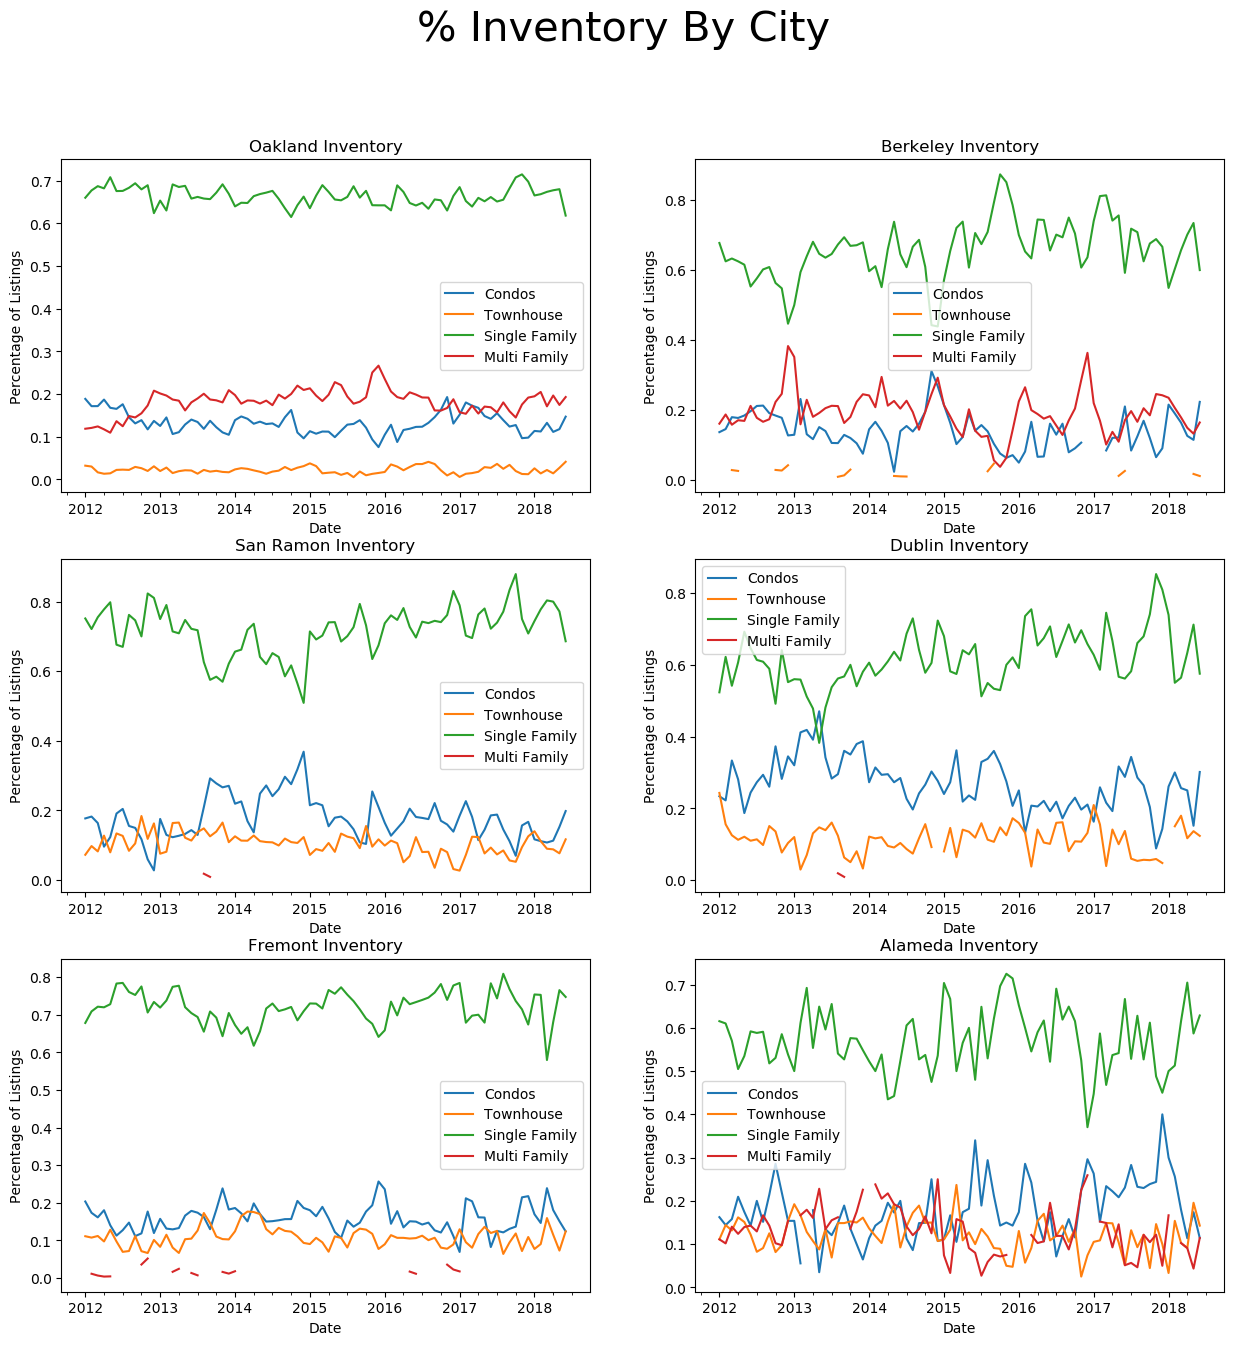

In [251]:
f, axs = plt.subplots(3,2,figsize=(15,15), dpi=100)

for index, city in enumerate(cities):
    plt.subplot(3,2,index+1)
    condos.loc[city]['Inventory'].divide(all_homes.loc[city]['Inventory']).plot(label="Condos")
    townhouse.loc[city]['Inventory'].divide(all_homes.loc[city]['Inventory']).plot(label="Townhouse")
    single_family.loc[city]['Inventory'].divide(all_homes.loc[city]['Inventory']).plot(label="Single Family")
    multi_family.loc[city]['Inventory'].divide(all_homes.loc[city]['Inventory']).plot(label="Multi Family")
    plt.legend()
    plt.ylabel('Percentage of Listings')
    plt.xlabel('Date')
    plt.title(f'{city} Inventory')

plt.suptitle('% Inventory By City', fontsize=30)
plt.show()

In [279]:
data = {
    'Condos': [],
    'Townhouse': [],
    'Single Family': [],
    'Multi Family': []
}

for city in cities:
    all_homes_average = all_homes.fillna(0).loc[city]['Inventory'].resample('Y').mean()
    
    condos_avg = condos.fillna(0).loc[city]['Inventory'].resample('Y').mean().divide(all_homes_average)['2017-12-31']
    data['Condos'].append(condos_avg)
    
    townhome_avg = townhouse.fillna(0).loc[city]['Inventory'].resample('Y').mean().divide(all_homes_average)['2017-12-31']
    data['Townhouse'].append(townhome_avg)
    
    single_avg = single_family.fillna(0).loc[city]['Inventory'].resample('Y').mean().divide(all_homes_average)['2017-12-31']
    data['Single Family'].append(single_avg)
    
    multi_avg = multi_family.fillna(0).loc[city]['Inventory'].resample('Y').mean().divide(all_homes_average)['2017-12-31']
    data['Multi Family'].append(multi_avg)
    

traces = []
for k,v in data.items():
    trace = go.Bar(
        x=cities,
        y=data[k],
        name=k
    )
    traces.append(trace)


layout = go.Layout(
    barmode='stack',
    title='2017 Average - Distribution of Home Inventory by Location',
    yaxis={
        'title': 'Percentage'
    },
    xaxis={
        'title': 'Location'
    }
)

fig = go.Figure(data=traces, layout=layout)
plotly.iplot(fig, filename='Inventory Percentage Bar Chart', show_link=False)
# plotly.plot(fig, image='svg', image_filename='2017-Inventory-Averages')

'file:///notebooks/Redfin Plots/temp-plot.html'

In [293]:
data = {
    'Condos': [],
    'Townhouse': [],
    'Single Family': [],
    'Multi Family': []
}

for city in cities:
    
    condos_sum = condos.fillna(0).loc[city]['Homes Sold'].resample('Y').sum()['2017-12-31']
    data['Condos'].append(condos_sum)
    
    townhome_sum = townhouse.fillna(0).loc[city]['Homes Sold'].resample('Y').sum()['2017-12-31']
    data['Townhouse'].append(townhome_sum)
    
    single_sum = single_family.fillna(0).loc[city]['Homes Sold'].resample('Y').sum()['2017-12-31']
    data['Single Family'].append(single_sum)
    
    multi_sum = multi_family.fillna(0).loc[city]['Homes Sold'].resample('Y').sum()['2017-12-31']
    data['Multi Family'].append(multi_sum)
    

traces = []
for k,v in data.items():
    trace = go.Bar(
        x=cities,
        y=data[k],
        name=k,
        text=data[k],
        textposition='auto'
    )
    traces.append(trace)


layout = go.Layout(
    barmode='stack',
    title='2017 Total Homes Sold by City',
    yaxis={
        'title': 'Number of Homes'
    }
)

fig = go.Figure(data=traces, layout=layout)
plotly.iplot(fig, filename='Inventory Percentage Bar Chart', show_link=False)
plotly.plot(fig, image='svg', image_filename='2017-Total-Homes-Sold')

'file:///notebooks/Redfin Plots/temp-plot.html'

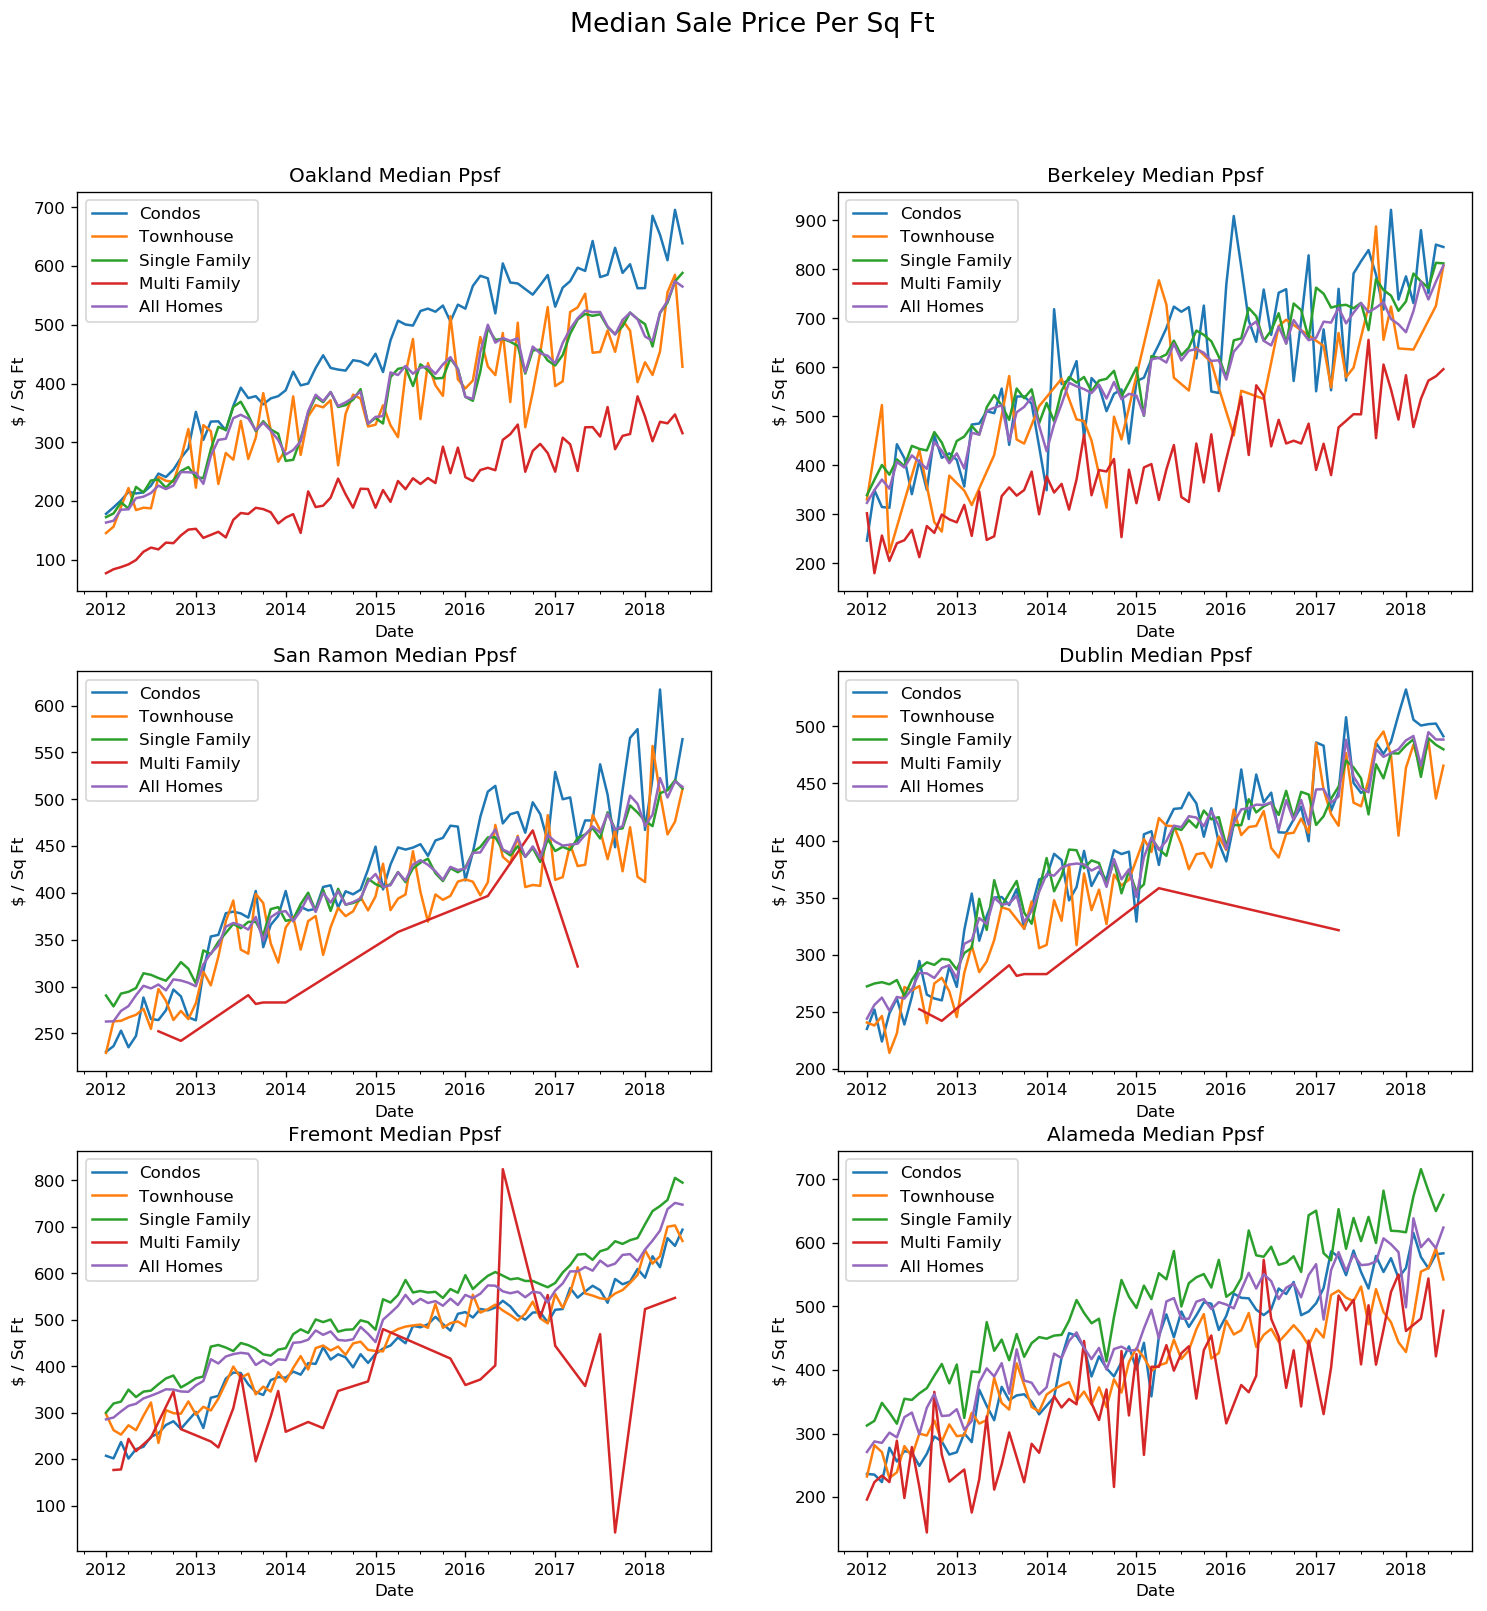

In [303]:
# f, axs = plt.subplots(3,2,figsize=(20,20))
fig, axes = plt.subplots(3, 2, figsize=(15,15), dpi=120)

indicator = 'Median Ppsf'

for index, city in enumerate(cities):
    plt.subplot(3,2,index+1)
    condos.loc[city][indicator].dropna().plot(label="Condos")
    townhouse.loc[city][indicator].dropna().plot(label="Townhouse")
    single_family.loc[city][indicator].dropna().plot(label="Single Family")
    multi_family.loc[city][indicator].dropna().plot(label="Multi Family")
    all_homes.loc[city][indicator].dropna().plot(label="All Homes")
    plt.ylabel('$ / Sq Ft')
    plt.xlabel('Date')
    plt.legend()
    plt.title(f'{city} {indicator}')

plt.suptitle('Median Sale Price Per Sq Ft', fontsize=16)
plt.show()

In [304]:
decomposed = seasonal_decompose(all_homes.loc['Oakland']['Median Sale Price'], model="additive")

In [318]:
trace1 = go.Scatter(
    x=decomposed.observed.index,
    y=decomposed.observed,
    name='Observed'
)

trace2 = go.Scatter(
    x=decomposed.seasonal.index,
    y=decomposed.seasonal,
    name='Seasonal'
)

trace3 = go.Scatter(
    x=decomposed.trend.index,
    y=decomposed.trend,
    name='Trend'
)

trace4 = go.Scatter(
    x=decomposed.resid.index,
    y=decomposed.resid,
    name='Residual'
)

fig = tools.make_subplots(rows=4, cols=1,shared_xaxes=True)

fig.append_trace(trace1,1,1)
fig.append_trace(trace2,2,1)
fig.append_trace(trace3,3,1)
fig.append_trace(trace4,4,1)

fig['layout'].update(
    title='Oakland Median Sale Price / SqFt Seasonal Decomposition',
    yaxis={'title': '$ / sqft'},
    yaxis2={'title': '$ / sqft'},
    yaxis3={'title': '$ / sqft'},
    yaxis4={'title': '$ / sqft'},
    legend={
        'orientation': 'h'
    }
    )

plotly.iplot(fig, filename='ETS Decomp', show_link=False)
# plotly.plot(fig, image='svg', image_filename='msp-all-oakland-seasonal', image_width=1080, image_height=960)

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]
[ (3,1) x1,y3 ]
[ (4,1) x1,y4 ]



'file:///notebooks/Redfin Plots/temp-plot.html'

In [194]:
def normalize_city_data(cities):
    output = {}
    for city in cities:
        output[city] = seasonal_decompose(normalize_series(all_homes.loc[city]['Median Sale Price']), model="additive")
    return output

In [331]:
def get_traces(df_dict):
    traces = []
    peaks = []
    for k,v in df_dict.items():
        trace = go.Scatter(
            x=v.seasonal.index,
            y=v.seasonal,
            name=k
        )
        trace_max = go.Scatter(
            showlegend=False,
            x=[v.seasonal.idxmax(),v.seasonal.idxmin()],
            y=[v.seasonal.max(), v.seasonal.min()],
            mode='markers+text',
            marker=dict(
                size=4,
                color='rgb(255,0,0)',
                symbol='cross'
            ),
            text=[v.seasonal.idxmax().month,v.seasonal.idxmin().month],
            textposition='middle right',
            textfont={
              'size': 14  
            },
            name='Peak'
        )
        traces.append(trace)
        peaks.append(trace_max)
    return (traces, peaks)

In [332]:
data = normalize_city_data(cities)

In [334]:
traces, peaks = get_traces(data)

fig = tools.make_subplots(rows=6, cols=1,shared_xaxes=True, vertical_spacing=0.01)

for index, trace in enumerate(traces):
    fig.append_trace(traces[index], index+1, 1)

for index, trace in enumerate(peaks):
    fig.append_trace(peaks[index], index+1, 1)

fig['layout'].update(
    title='Seasonalily Across Cities - Median Price', 
    legend={
        'orientation': 'h'
    }
)

plotly.iplot(fig, filename='Seasonal Trend Analysis', show_link=False)
# plotly.plot(fig, image='svg', image_filename='seasonal-trace-all-cities', image_width=1080, image_height=960)

This is the format of your plot grid:
[ (1,1) x1,y1 ]
[ (2,1) x1,y2 ]
[ (3,1) x1,y3 ]
[ (4,1) x1,y4 ]
[ (5,1) x1,y5 ]
[ (6,1) x1,y6 ]



'file:///notebooks/Redfin Plots/temp-plot.html'